# Нужно решить, где бурить новую скважину. 

Имеются пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 

**Задача:** Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. 

**Цель:** Проанализируйте возможную прибыль и риски техникой Bootstrap.

**Данные синтетические**

---

# Загрузка и подготовка данных

---

In [1]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RANDOM_STATE=54321

# настройки
warnings.filterwarnings("ignore")

In [2]:
# Создадим функцию, так как у нас 3 датасета
def get_data_info(data):
    display(data.head()) 
    display(data.info())
    display(data.describe())
    display(data.hist(figsize = (15,15))) 
    print('Количество пропусков в %')
    display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('BuPu'))
    print('Проверка на явные дубликаты')
    display(data[data.duplicated()]) 
    print('Проверка на неявные дубликаты')
    display(data[data[['id']].duplicated()])  
    print('Количество дубликатов:', data['id'].duplicated().sum())
    print('Суммарный объем нефти (млн. баррелей) в данном регионе:', data['product'].sum())
    
    
    plt.figure(figsize = (20,20)) # указываем размеры 
    plt.subplot(3, 3, 1)
    display(sns.heatmap((data).corr(), annot = True, vmin=-1, vmax=1, center= 0)) # значения корреляции через хитмэп
    plt.subplot(3, 3, 2)
    display(sns.boxplot(data=data)); # boxplot
    
    columns = ['f0', 'f1', 'f2']
    plt.figure(figsize = (15,15))
    for i in columns:
        display(data.plot(title = f'Корреляция между {i} и product', # наглядно увидим как именно коррелируют признаки
                           kind='scatter' ,
                           y = i, 
                           x ='product'))
        

> Напоминалка
>* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
>* product — объём запасов в скважине (тыс. баррелей).

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

Количество пропусков в %


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


Проверка на явные дубликаты


,id,f0,f1,f2,product


Проверка на неявные дубликаты


,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


Количество дубликатов: 10
Суммарный объем нефти (млн. баррелей) в данном регионе: 9250000.000000002


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:title={'center':'Корреляция между f0 и product'}, xlabel='product', ylabel='f0'>

<AxesSubplot:title={'center':'Корреляция между f1 и product'}, xlabel='product', ylabel='f1'>

<AxesSubplot:title={'center':'Корреляция между f2 и product'}, xlabel='product', ylabel='f2'>

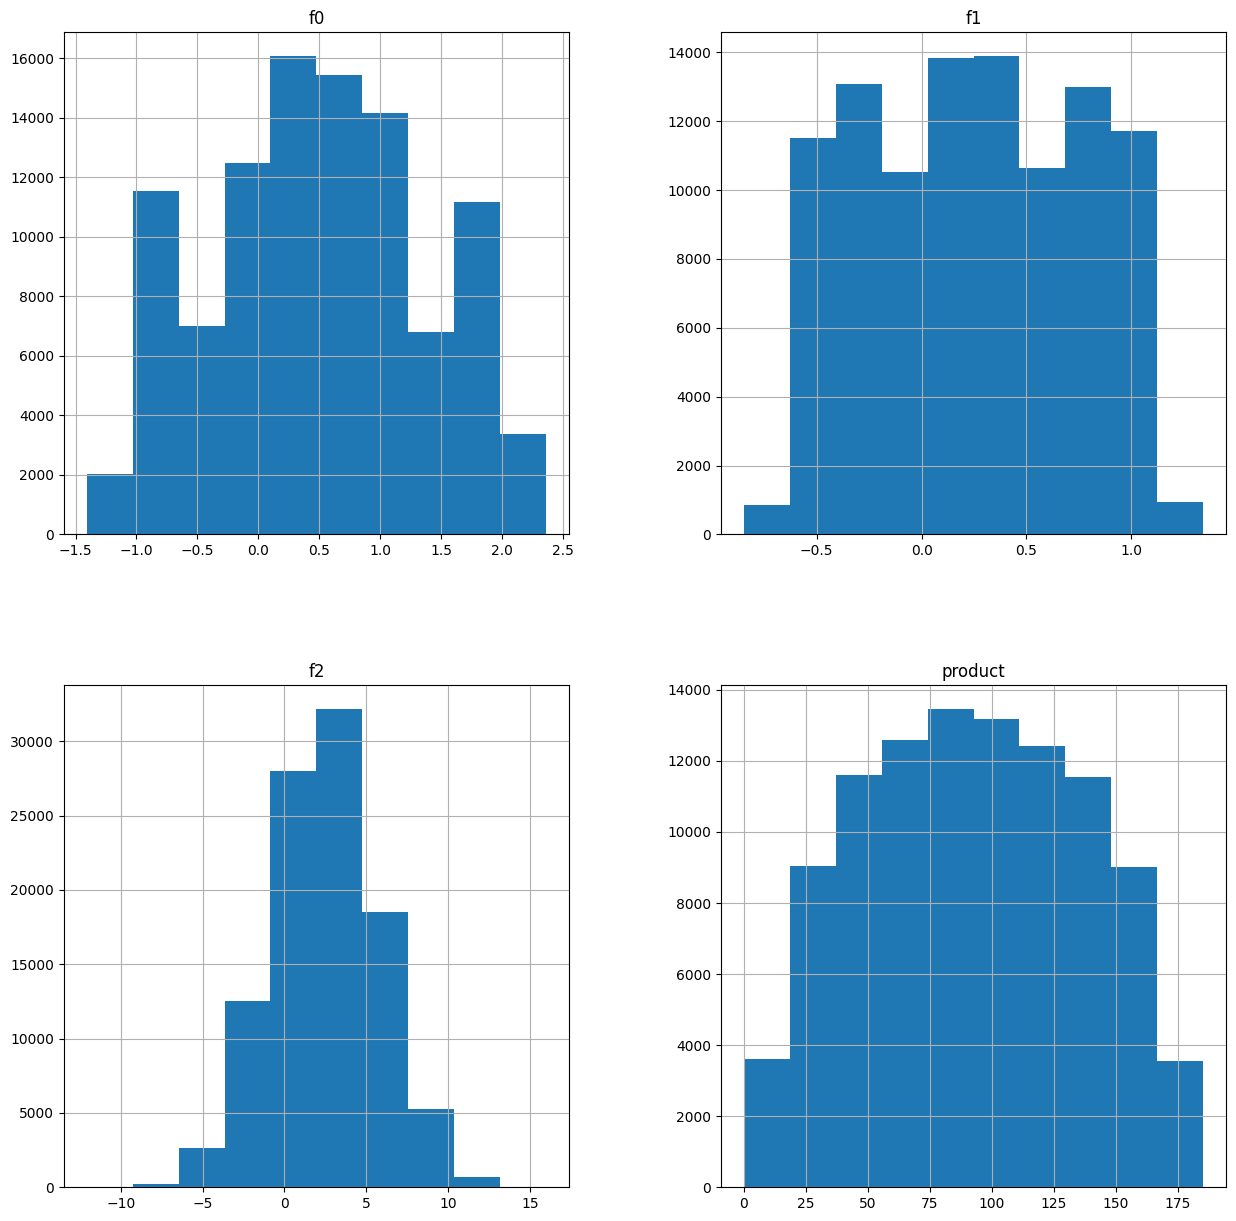

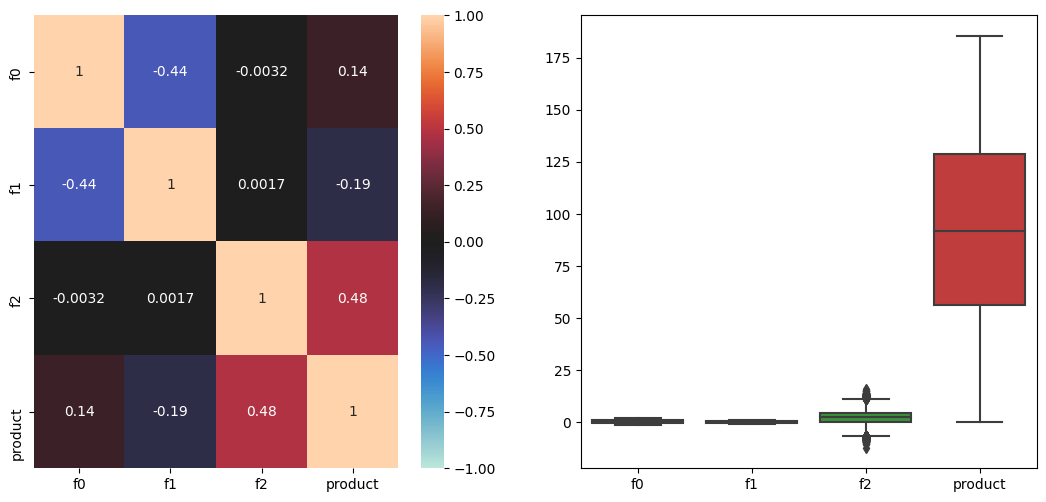

<Figure size 1500x1500 with 0 Axes>

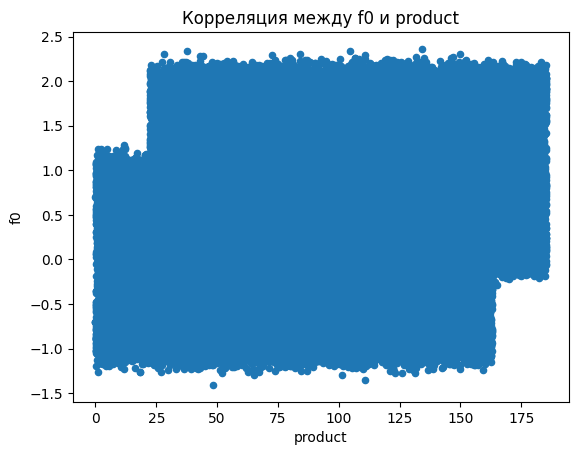

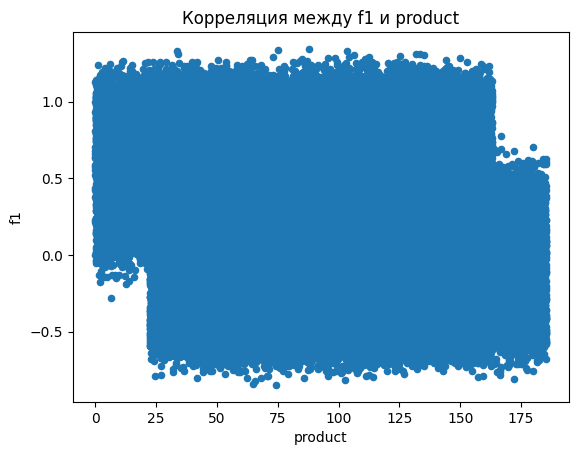

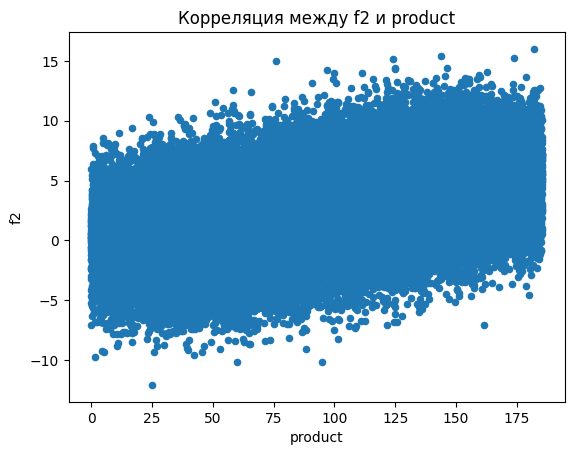

In [3]:
# geo_data_0
df_1 = pd.read_csv('.\\data\\geo_data_0.csv')
get_data_info(df_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

Количество пропусков в %


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


Проверка на явные дубликаты


,id,f0,f1,f2,product


Проверка на неявные дубликаты


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


Количество дубликатов: 4
Суммарный объем нефти (млн. баррелей) в данном регионе: 6882500.000000002


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:title={'center':'Корреляция между f0 и product'}, xlabel='product', ylabel='f0'>

<AxesSubplot:title={'center':'Корреляция между f1 и product'}, xlabel='product', ylabel='f1'>

<AxesSubplot:title={'center':'Корреляция между f2 и product'}, xlabel='product', ylabel='f2'>

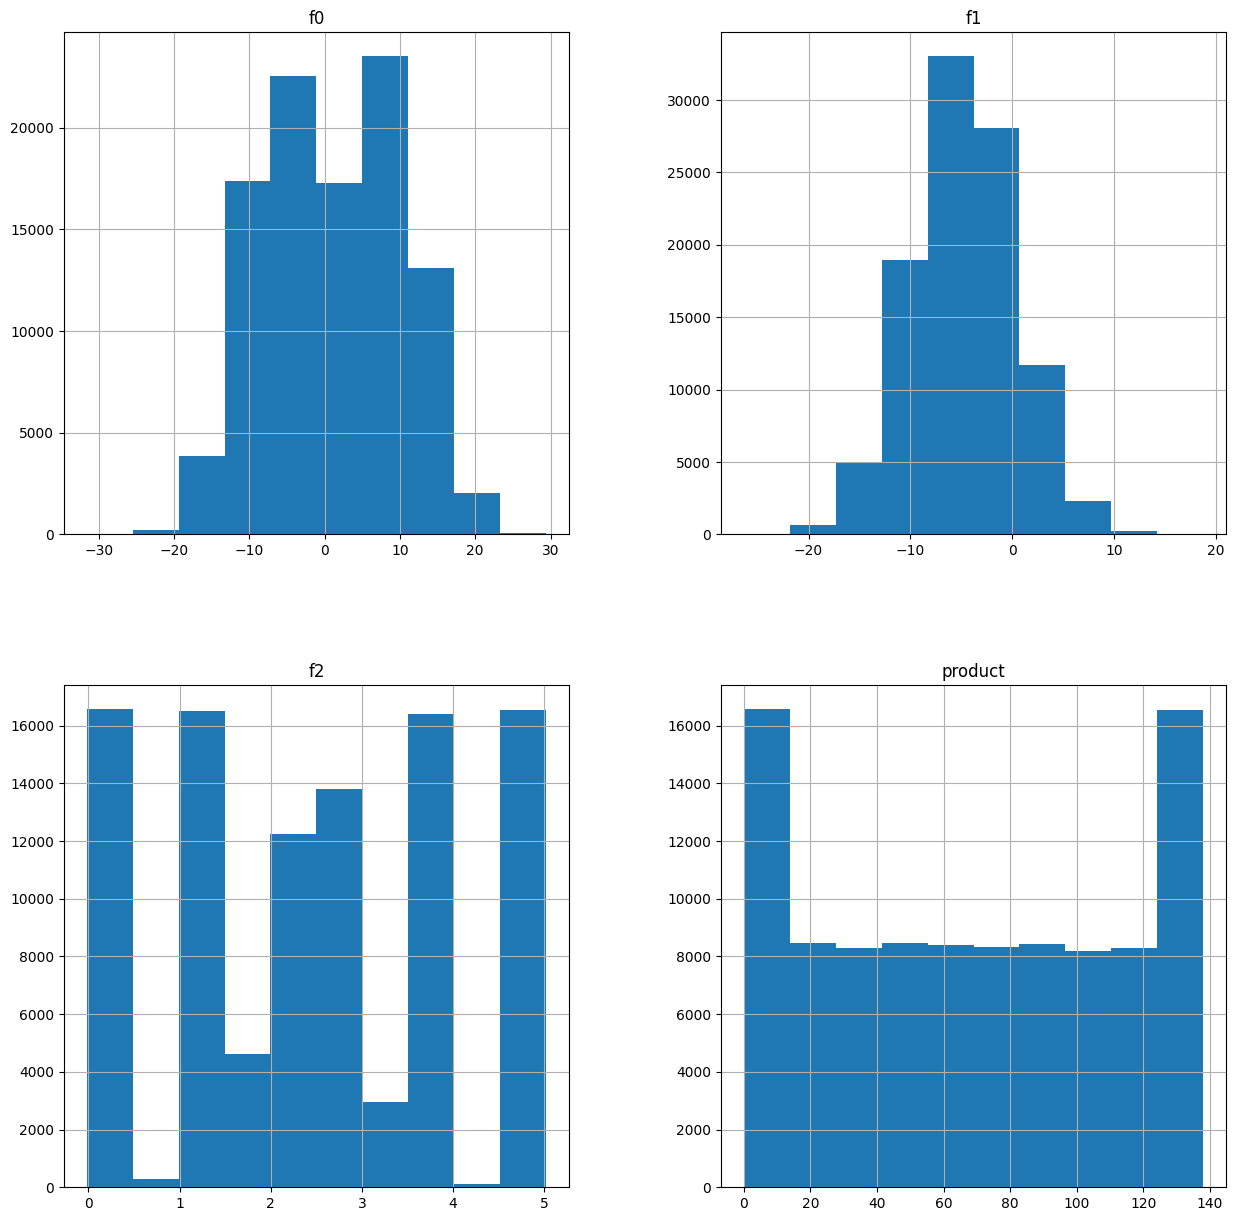

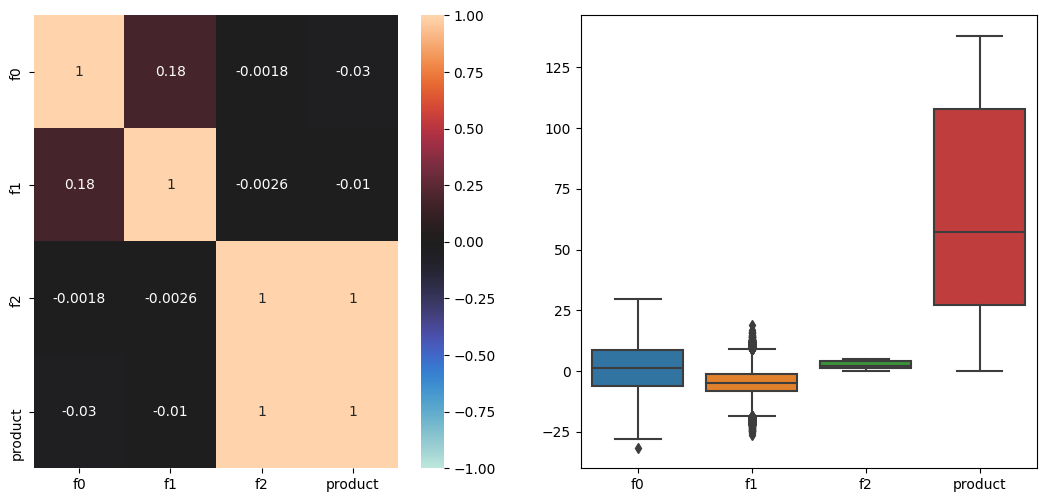

<Figure size 1500x1500 with 0 Axes>

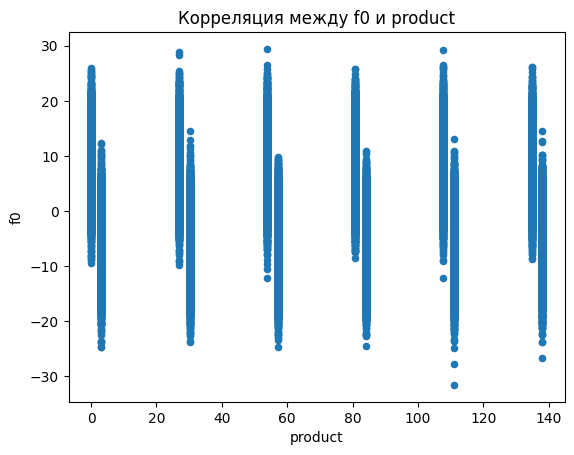

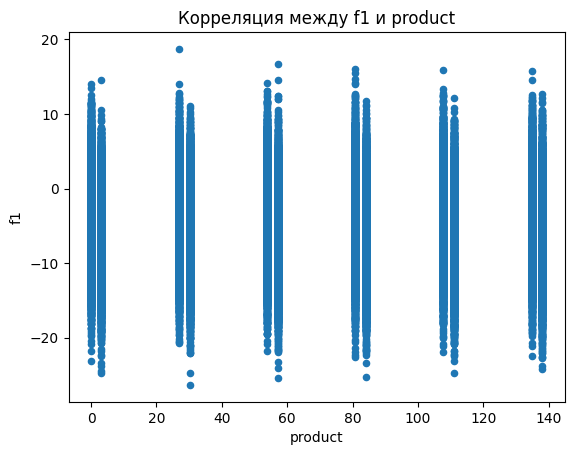

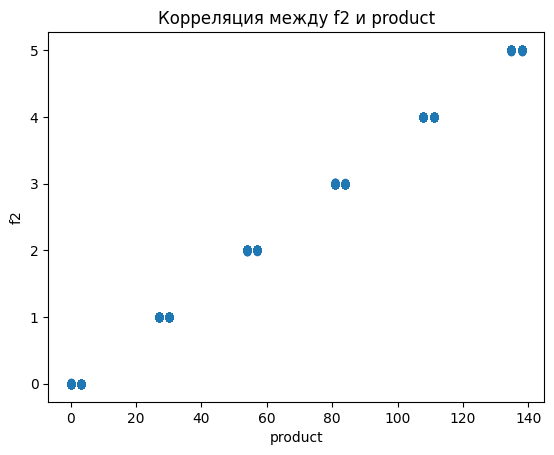

In [4]:
# geo_data_1
df_2 = pd.read_csv('.\\data\\geo_data_1.csv')
get_data_info(df_2);

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

Количество пропусков в %


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


Проверка на явные дубликаты


,id,f0,f1,f2,product


Проверка на неявные дубликаты


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Количество дубликатов: 4
Суммарный объем нефти (млн. баррелей) в данном регионе: 9500000.000000004


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:title={'center':'Корреляция между f0 и product'}, xlabel='product', ylabel='f0'>

<AxesSubplot:title={'center':'Корреляция между f1 и product'}, xlabel='product', ylabel='f1'>

<AxesSubplot:title={'center':'Корреляция между f2 и product'}, xlabel='product', ylabel='f2'>

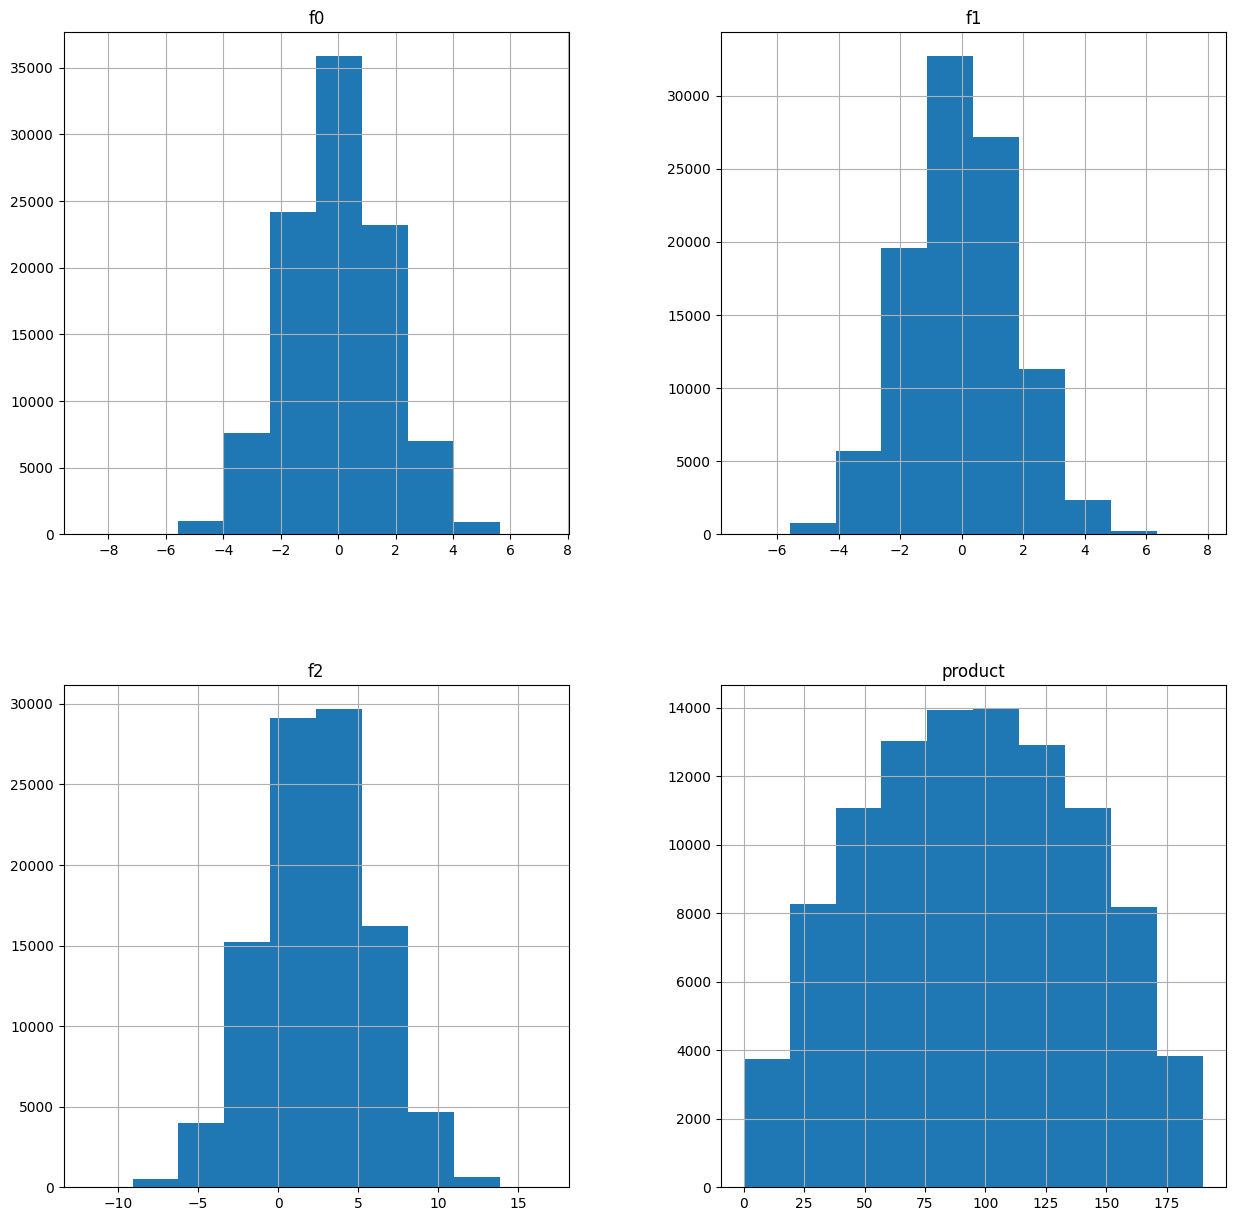

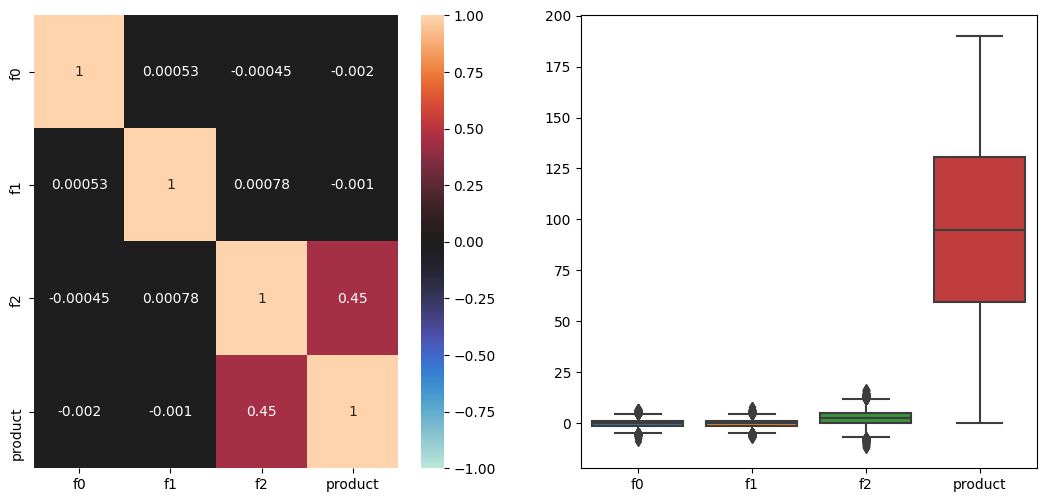

<Figure size 1500x1500 with 0 Axes>

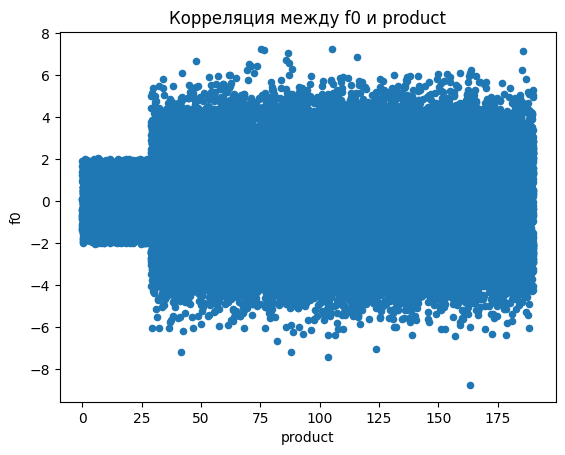

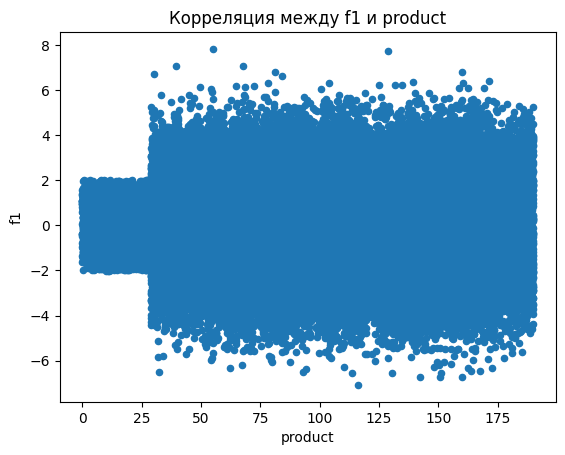

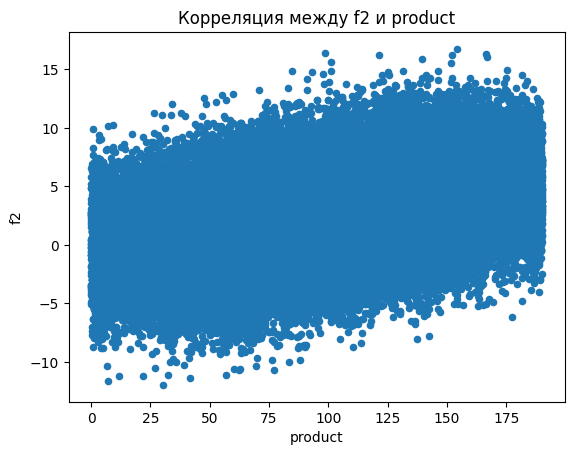

In [5]:
# geo_data_2
df_3 = pd.read_csv('.\\data\\geo_data_2.csv')
get_data_info(df_3)

**Вывод после загрузки данных:**
* имеются неявные дубликаты
* признак f2 везде неплохо коррелирует с целевым признаком: product. Особенно во втором регионе(df_2): корреляция равна 1
* остальные признаки не влияют на объем запасов нефти
* В 1 и 3 регионах распределение запасов нефти близко в нормальному распределению. Чего не скажешь о втором регионе
* Почему-то в 1 регионе признаки f1 и f0 коррелируют
* суммарный объем нефти:
  * в df_1: 9 250 000
  * в df_2: 6 882 500
  * в df_3: 9 500 000
  
*Во втором регионе в сумме меньше всего запасов нефти*

*В третьем регионе и медианное значение, и максимальное значение product больше всех*

In [6]:
# Дропаем дубликаты, так как это системная ошибка
df_1 = df_1.drop_duplicates(subset = ['id'], keep = False).reset_index(drop=True)
df_2 = df_2.drop_duplicates(subset = ['id'], keep = False).reset_index(drop=True)
df_3 = df_3.drop_duplicates(subset = ['id'], keep = False).reset_index(drop=True)

In [7]:
# Теперь можно дропнуть ненужный категоральный столбец
df_1 = df_1.drop(['id'], axis = 1)
df_2 = df_2.drop(['id'], axis = 1)
df_3 = df_3.drop(['id'], axis = 1)

---

# Обучение и проверка модели для каждого региона

---

In [8]:
# Создадим функцию
def split_and_hist(data):
    
    features = data.drop(['product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size= 0.25, 
                                                                                  random_state = RANDOM_STATE)
    print('Размер тренировочной выборки:', len(target_train))
    print('Размер валидационной выборки:', len(target_valid))
    
    # Промасштабируем признаки, так как линейные модели очень чувствительны 
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train) # обучение на трейне
    features_valid = scaler.transform(features_valid)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions) # превращаем в Series 
    
    
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    r2 = r2_score(target_valid, predictions)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'R2: {r2:.2f}')
    print(f'Cредний запас предсказанного сырья: {predictions.mean():.2f}')

    # гистограммы
    plt.figure(figsize = (20,20))
    plt.subplot(3,3,1)
    predictions.hist(color = 'pink')
    plt.title('Распределение предсказаний');
    plt.subplot(3,3,2)
    target_valid.hist();
    plt.title('Распределение правильных ответов')
    
    return (predictions, target_valid.reset_index(drop=True), rmse)

---

## Первый регион: df_1

---

Размер тренировочной выборки: 74985
Размер валидационной выборки: 24995
RMSE: 37.82
R2: 0.27
Cредний запас предсказанного сырья: 92.62


(0         90.775524
 1         88.465907
 2         93.786631
 3         66.089472
 4         97.316682
             ...    
 24990    125.059755
 24991     93.307212
 24992     85.028033
 24993     78.603617
 24994     84.504123
 Length: 24995, dtype: float64,
 0         57.986069
 1         24.008234
 2         96.418514
 3         45.089011
 4         56.841896
             ...    
 24990    168.778184
 24991     26.666660
 24992     78.844680
 24993     51.642658
 24994     60.321311
 Name: product, Length: 24995, dtype: float64,
 37.81704338243996)

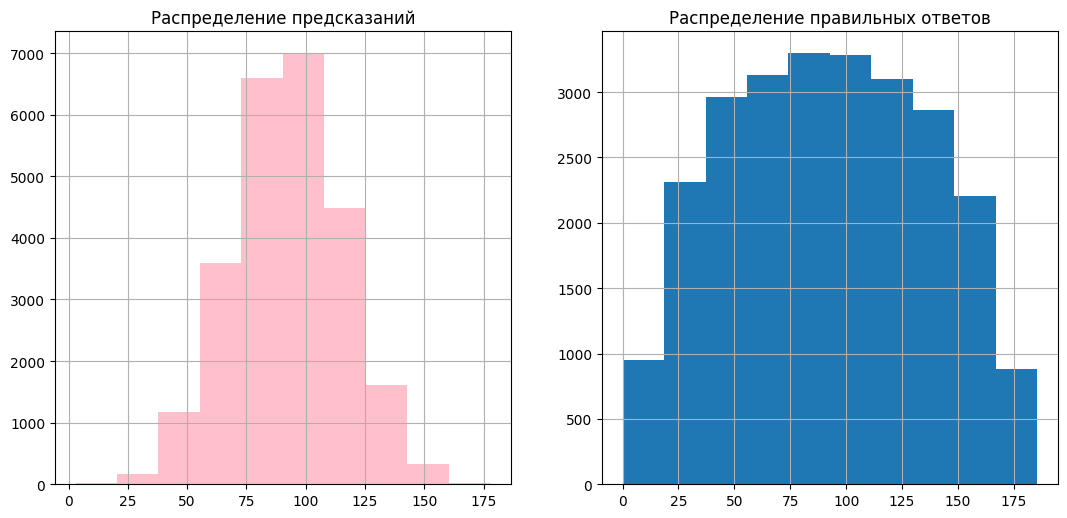

In [9]:
split_and_hist(df_1)

---

## Второй регион: df_2

---

Размер тренировочной выборки: 74994
Размер валидационной выборки: 24998
RMSE: 0.89
R2: 1.00
Cредний запас предсказанного сырья: 68.63


(0        109.890103
 1        134.239330
 2         -0.110539
 3         81.251138
 4         28.842697
             ...    
 24993     81.003361
 24994     56.935279
 24995     80.785585
 24996     27.925237
 24997    137.265936
 Length: 24998, dtype: float64,
 0        110.992147
 1        134.766305
 2          0.000000
 3         80.859783
 4         30.132364
             ...    
 24993     80.859783
 24994     57.085625
 24995     80.859783
 24996     26.953261
 24997    137.945408
 Name: product, Length: 24998, dtype: float64,
 0.8926275494139505)

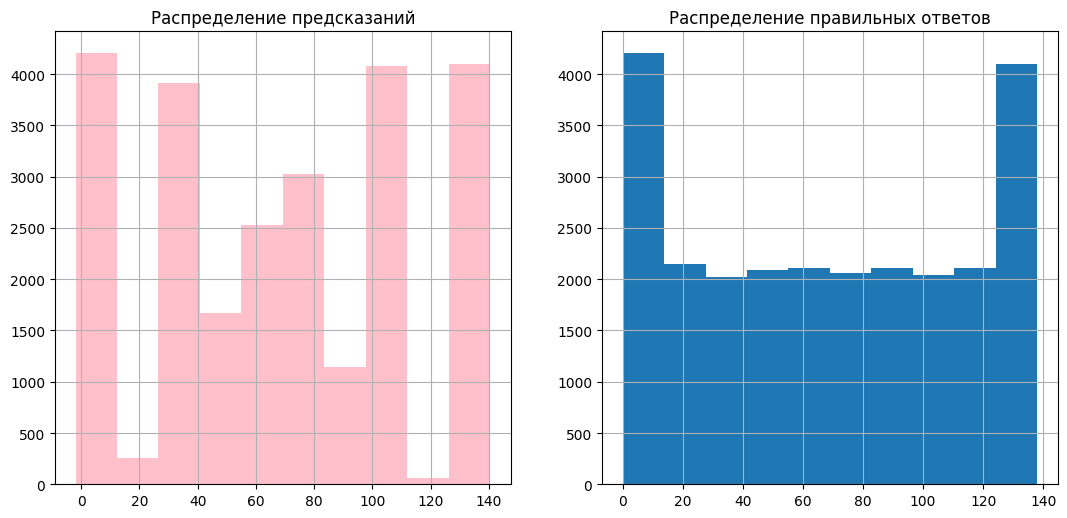

In [10]:
split_and_hist(df_2)

---

## Третий регион: df_3

---

Размер тренировочной выборки: 74994
Размер валидационной выборки: 24998
RMSE: 40.03
R2: 0.20
Cредний запас предсказанного сырья: 94.98


(0         68.654965
 1         88.575340
 2         53.389439
 3         87.365140
 4        128.749208
             ...    
 24993     74.881566
 24994    108.507131
 24995     98.386934
 24996     79.851963
 24997     76.830591
 Length: 24998, dtype: float64,
 0        140.506063
 1        109.115605
 2         53.766882
 3         77.483680
 4         42.073871
             ...    
 24993     45.055445
 24994     98.942481
 24995    129.069265
 24996     84.480956
 24997     65.403172
 Name: product, Length: 24998, dtype: float64,
 40.02965623706749)

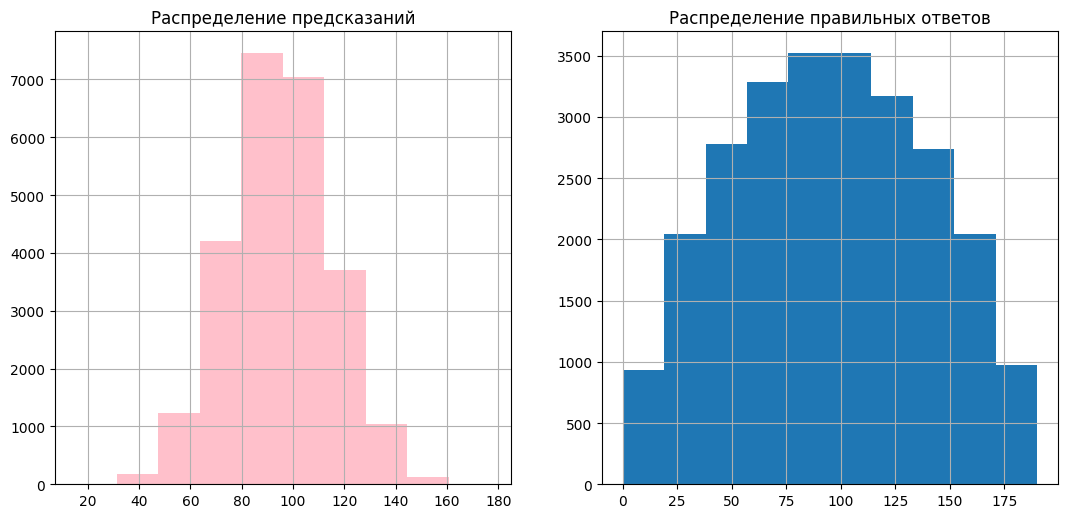

In [11]:
split_and_hist(df_3)

---

**Вывод после обучения и проверки модели для каждого региона:**
* первый регион (df_1):
  * RMSE модели: 37.82
  * R2 модели: 0.27
  * Cредний запас предсказанного сырья: 92.62
  
  
* второй регион (df_2):
  * RMSE модели: 0.89
  * R2 модели: 1.00
  * Cредний запас предсказанного сырья: 68.63
  
  
* третий регион (df_3):
  * RMSE модели: 40.03
  * R2 модели: 0.20
  * Cредний запас предсказанного сырья: 94.98
  
*Видно, что **модель второго региона наилучшая**, так как у нее RMSE меньше всего, а R2 = 1. То есть модель лучше предсказывает данные, меньше расхождений с правильными ответами*
  
* **MSE** -  метрика, которая сообщает нам среднеквадратичную разницу между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем **ниже** MSE, тем **лучше** модель соответствует набору данных.


* **RMSE** -  метрика, которая сообщает нам квадратный корень из средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем **ниже** RMSE, тем **лучше** модель соответствует набору данных.


* *При оценке того, насколько хорошо модель соответствует набору данных, мы чаще используем **RMSE** , потому что он измеряется в тех же единицах, что и переменная ответа.*

**R2  (коэф. детерминации)**: вычисляет долю средней квадратичной ошибки (MSE) от MSE среднего, а затем вычитает эту величину из единицы. Выражена в относительных единицах. Чем **выше R2**, тем **качественнее** модель

  * R2 = 1 (MSE = 0) - идеальная модель, все ответы правильные
  * R2 = 0 - модель работает также, как и среднее
  * R2 < 0 - качество модели очень низкое
  * R2 > 1 - не бывает

Размер тренировочной выборки: 74985
Размер валидационной выборки: 24995
RMSE: 37.82
R2: 0.27
Cредний запас предсказанного сырья: 92.62
Размер тренировочной выборки: 74994
Размер валидационной выборки: 24998
RMSE: 0.89
R2: 1.00
Cредний запас предсказанного сырья: 68.63
Размер тренировочной выборки: 74994
Размер валидационной выборки: 24998
RMSE: 40.03
R2: 0.20
Cредний запас предсказанного сырья: 94.98


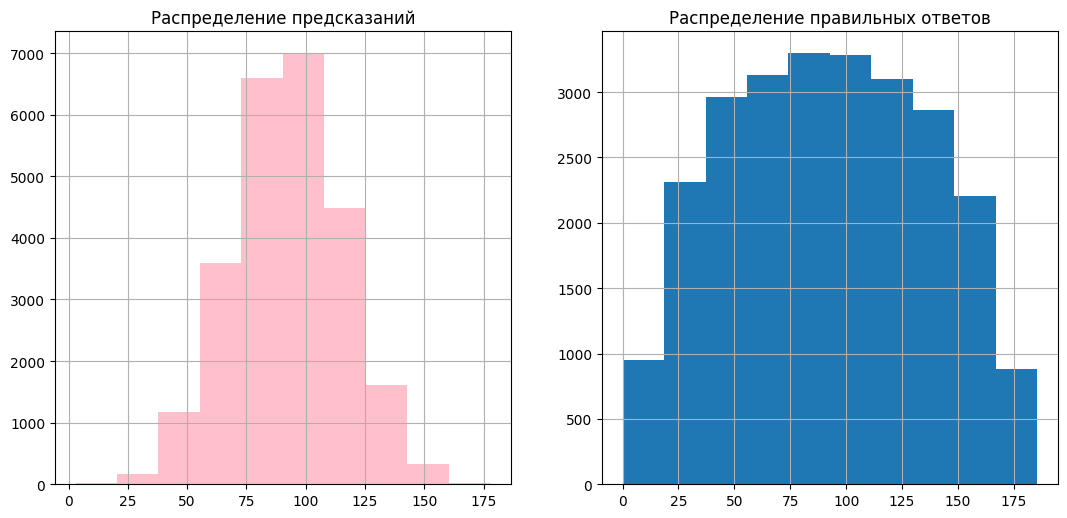

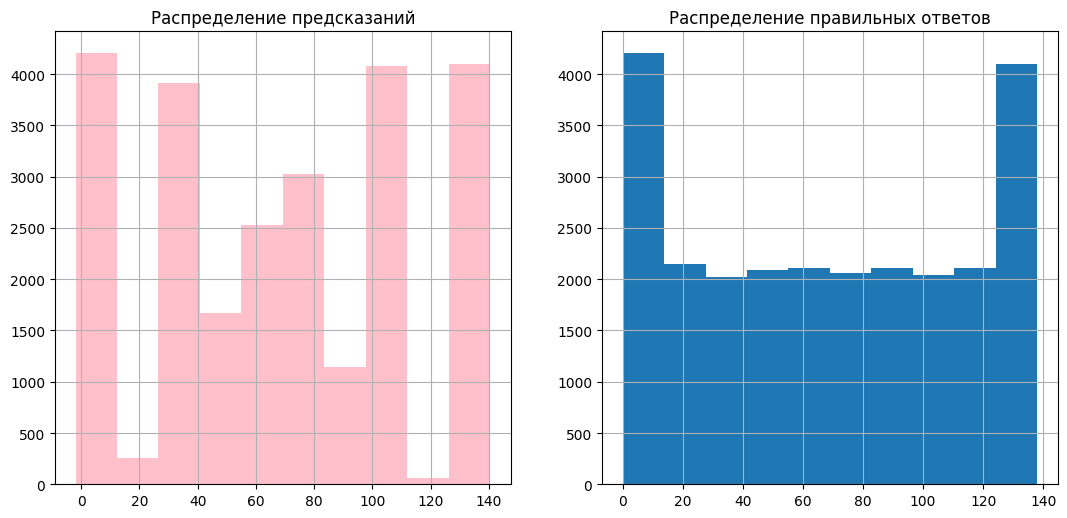

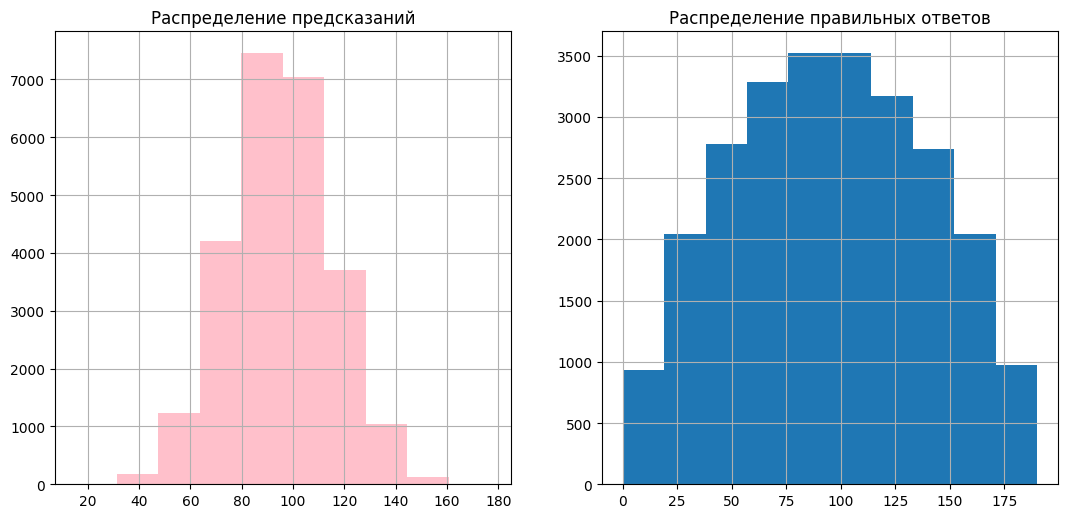

In [12]:
# Разместим все по своим местам
predictions_1, target_valid_1, rmse_1 = split_and_hist(df_1)
predictions_2, target_valid_2, rmse_2 = split_and_hist(df_2)
predictions_3, target_valid_3, rmse_3 = split_and_hist(df_3)

---

# Подготовка расчета прибыли

---

*Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе*

**Условия задачи:**

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**То есть безубыточная разработка - та, которая принесет больше 10 млрд рублей**

**Ставим следующий вопрос: сколько минимум нужно тыс баррелей нефти, чтобы разработка была безубыточной, если 1 тыс быррель приносит 450 тыс. рублей?**

In [13]:
BUDGET = 10000000000 # 10 млрд рублей
ONE_THOUSAND_BARREL = 450000 # 450000 за 1 тыс баррель нефти
MIN_VOLUME_OF_OIL = BUDGET /ONE_THOUSAND_BARREL # минимальный объем нефти для разработки в тыс баррель
print('Минимальный объем нефти для разработки в тыс баррель (точка безубыточности) для региона:', MIN_VOLUME_OF_OIL)

Минимальный объем нефти для разработки в тыс баррель (точка безубыточности) для региона: 22222.222222222223


In [84]:
# Так как мы отбираем 200 лучших точек, то делим на 200
oil_mean =  MIN_VOLUME_OF_OIL/200
print("Точка безубыточности для разрабатываемых 200 скважин:", oil_mean)

Точка безубыточности для разрабатываемых 200 скважин: 111.11111111111111


> Сравним со средним объемом нефти в скважинах в каждом регионе
>* df_1: 92.5
>* df_2: 68.825
>* df_3: 95.0

> **Средний запас сырья в скважинах меньше, чем точка безубыточности**

---

# Риски и  прибыль каждого региона

---

>**Доверительный интервал** — отрезок числовой оси, в который с заданной вероятностью попадает нужный нам параметр генеральной совокупности. Параметр неизвестен, но его можно оценить по выборке. Если величина с вероятностью 95% попадает в интервал от 300 до 500, то 95%-й доверительный интервал для неё — это (300, 500).

> При вычислении доверительного интервала с каждой из его сторон обычно выбрасывают одинаковую долю экстремальных значений. Для построения 95%-го доверительного интервала нужно выкинуть 5% экстремальных значений, то есть 2.5% самых больших и 2.5% самых маленьких. 

> Для построения 95%-го доверительного интервала нужно выбрать 0.025-квантиль и 0.975-квантиль. 97.5% - 2.5% = 95%

In [17]:
# Подготовим фактические данные: суммарный доход лучших 200 точек
def revenue(predictions, target_valid, count):
    probs_sorted = predictions.sort_values(ascending=False)
    selected = target_valid[probs_sorted.index][:count]
    result = ONE_THOUSAND_BARREL * selected.sum()
    return result - BUDGET

In [18]:
state = np.random.RandomState(12345)
def finish(predictions, target_valid):
    values = []
    for i in range(1000):
        target_subsample = target_valid.sample(n = 500, replace = True, random_state = state)
        probs_subsample = predictions[target_subsample.index]
        res = revenue(probs_subsample, target_subsample, 200)
        values.append(res)

    values = pd.Series(values)
    mean = values.mean()
    high = values.quantile(0.975) # подсчет 95%-го доверительного интервала
    low = values.quantile(0.025) # подсчет 95%-го доверительного интервала
    return mean, high, low, values

In [19]:
s = 1
for predictions, target_valid in zip([predictions_1, predictions_2, predictions_3],
                         [target_valid_1, target_valid_2, target_valid_3]):
        
    mean, high, low, values = finish(predictions, target_valid)
    print(f'Region {s}:')
    print('Средняя выручка в млрд рублей:',mean)
    print('95% доверительный интервал:', (low, high))
    
    # Если значения в values меньше бюджета, то такая разработка  убыточная 
    print('Риск в % для разработки:', (values < 0).mean()*100) # mean() можно заменить на count()/1000
    print('_____________')
    s+=1

Region 1:
Средняя выручка в млрд рублей: 399548068.69357884
95% доверительный интервал: (-139453706.6847052, 921187056.4184318)
Риск в % для разработки: 7.1
_____________
Region 2:
Средняя выручка в млрд рублей: 495840621.2356764
95% доверительный интервал: (105117068.14683558, 936641757.5920101)
Риск в % для разработки: 1.3
_____________
Region 3:
Средняя выручка в млрд рублей: 376224905.1068073
95% доверительный интервал: (-193752956.52100486, 920304982.2589533)
Риск в % для разработки: 10.2
_____________


---

<h1>Вывод:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

1. Проанализировали данные
2. Нашли 95%-ый доверительный интервал
3. Нашли среднюю выручку
4. Рассчитали риски разработки

Несмотря на то, что во **2-ом** регионе суммарный объем нефти меньше всего, **2-ой регион** обладает следующими преимуществами: 
* Хорошая корреляция показателей с продуктом
* Низкий риск разработки
* Модель 2-го региона показала наилучшие результаты метрик rmse и r2
* Хороший доверительный интервал, который отражает действительно прибыльную разработку (отрезок состоит из положительных чисел, которые больше бюджета)
  * значение f2(корреляция с продуктом равна 1) во 2 регионе не имеет выбросов, если смотреть на boxplot. В отличие от других регионов, где показатель f2 тоже неплохо коррелирует с продутом
* Большая средняя выручка (в отличие от двух других регионов)

**2-ой регион является более перспективным для разработки новой скважины**